# Figure - Weight Correlation Example

April 29, 2022

Notebook Edited from `New-Covariance-Metric-2022-4-28.ipynb`

The goal is to show that we can see how the _weight updates_ correlate with different decoders. This is a nice example that sets up the covariance metric used in the rest of the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [13]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories,plot_position
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [70]:
def paper_format():
    lw = 2
    fontsize = 12
    return lw, fontsize

def presentation_format():
    lw = 2
    fontsize = 14
    return lw, fontsize

### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [5]:
trial_duration = 20
n_in=4
frac_on = 1.0

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# RFLO, 1 Target Task

In [6]:
# define f and df

def f_linear(x):
    return x

def df_linear(x):
    return 1

24it [00:00, 239.93it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fac436f19d8>


500it [00:00, 502.83it/s]


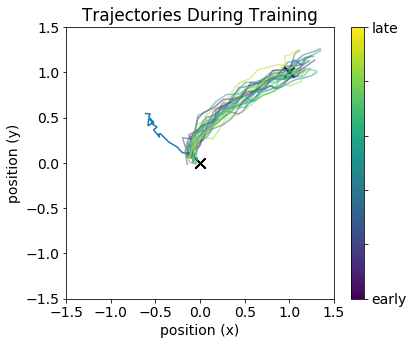

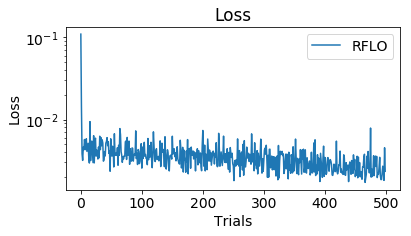

In [7]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               g_rec=0.5,
               rng=np.random.RandomState(8))
params.print_params()

# Initialize RNN
net0 = RNN(params,f=f_linear,df=df_linear)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)




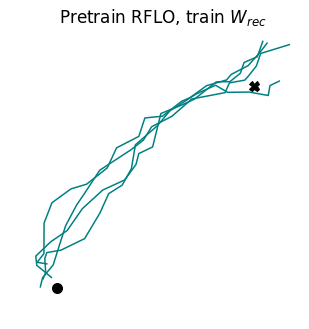

In [8]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')


## Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

In [9]:
overlap = 0.6
n_change = 50
w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)
w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000)

# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,w_out1)
print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out1 and w_m
norm, angle = return_norm_and_angle(w_out1,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

# confirm overlap between w_out and w_m
norm, angle = return_norm_and_angle(net0.w_out,w_m)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')

M norm: 1.15	 M angle: 0.60, 1 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.65	 w_out vs. w_m angle: 0.33

## Train with RFLO

500it [00:00, 725.13it/s]
500it [00:01, 305.21it/s]
500it [00:00, 783.86it/s]


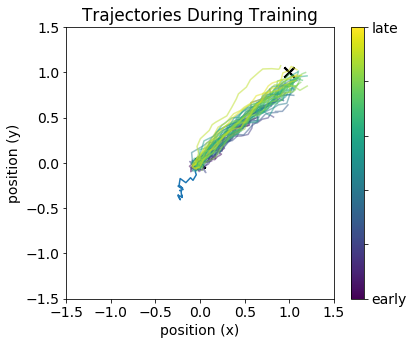

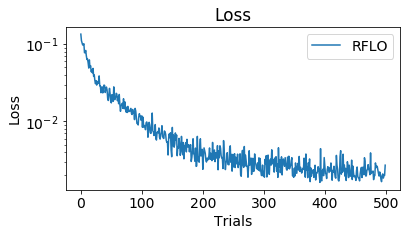

In [11]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False)
sim1_train.run_session(n_trials=500, tasks=[task1], learn_alg=[rflo], probe_types=['h','loss','err','w_rec','pos'], plot=True, plot_freq=10)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


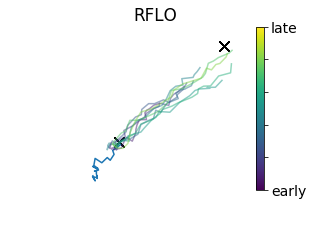

In [63]:
""" Plot example trajectories during training """
save = True
if save:
    lw, fs = paper_format()
    
fig,ax = plt.subplots(1,1,figsize=(4,3))
n_trials=250
plot_freq = 25

for n in np.arange(0,n_trials,plot_freq):
    count = n
    fig = plot_position(fig=fig, pos=sim1_train.session_probes['pos'][n], tasks = [task1], n_trials=n_trials,count=count,plot_freq=plot_freq)
    
    
ax.set_xlim([-0.5,1.2])
ax.set_ylim([-0.5,1.2])
ax.set_axis_off()
fig.show()

if save:
    ax.set_title("RFLO")
    fig.savefig('rflo-trajectories-example.pdf')

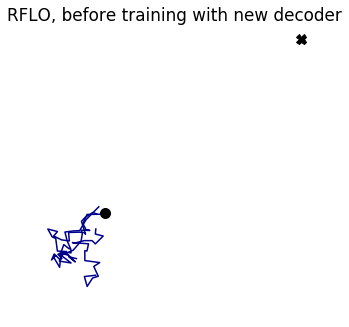

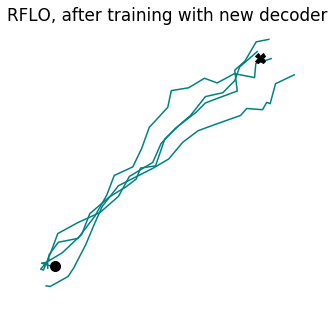

In [30]:
fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1],title='RFLO, before training with new decoder')

fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1],title='RFLO, after training with new decoder')


number of trials:  500
n_samples,n_features:  (499, 2500)
C:  (50, 2500)


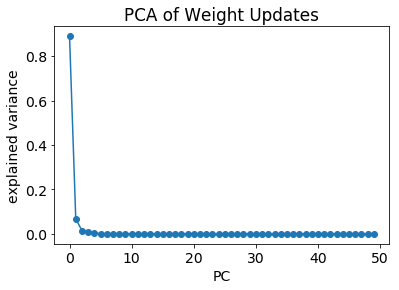

In [37]:
""" PCA on the weight updates """

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=50)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.title('PCA of Weight Updates')
plt.show()

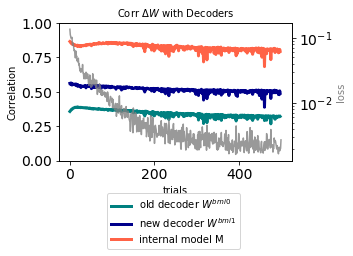

In [57]:

""" Compare Change in Weights"""


save = True

if save:
    lw,fs = paper_format()

fig,ax = plt.subplots(1,1,figsize=(5,4))

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim1_train.session_probes['loss']),axis=1)
ax1.plot(loss,color='gray',alpha=0.8)
ax1.set_ylabel('loss',color='gray',fontsize=fs)
ax1.set_yscale('log')

""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
    delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)
    
#     corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
#     corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

    
    """ not the average """
#     corrs_w_out0.append(np.corrcoef(deltaW1.ravel(),delta_w_out0.ravel())[0,1])
#     corrs_w_out.append(np.corrcoef(deltaW1.ravel(),delta_w_out.ravel())[0,1])
#     corrs_w_m.append(np.corrcoef(deltaW1.ravel(),delta_w_m.ravel())[0,1])
    
    
    """ average """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

ax.plot(corrs_w_out0,'-',label='old decoder '+r'$W^{bmi0}$',color='teal',linewidth=3)
ax.plot(corrs_w_out,'-',label='new decoder '+r'$W^{bmi1}$',color='darkblue',linewidth=3)
ax.plot(corrs_w_m,'-',label='internal model M',color='tomato',linewidth=3)
ax.set_ylim([0,1])


#ax1.set_ylim(top=np.max(loss))

ax.legend(bbox_to_anchor=(0.8,-0.2),fontsize=fs)
plt.title('Corr '+r'$\Delta W$'+ ' with Decoders',fontsize=fs)
ax.set_ylabel('Correlation',fontsize=fs)
ax.set_xlabel('trials',fontsize=fs)
plt.tight_layout()


if save:
    fig.savefig('rflo-W-correlation.pdf')

# REINFORCE

In [58]:
""" Use same Pretraining and Networks as above """

' Use same Pretraining and Networks as above '

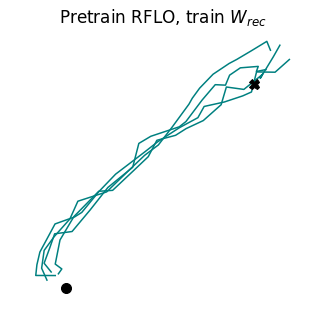

In [219]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1],title='Pretrain RFLO, train '+r'$W_{rec}$')


## Apply gradient calculation to two separate learning rules

First we choose a new decoder `w_out1` such that it has an overlap alignment of 0.6 with the old decoder `w_out0`.

Then we define an "internal model of credit assignment" matrix `w_m` that overlaps with the new decoder by 0.6.

Since these are selected randomly, the overlap of the internal model `w_m` with the old decoder `w_out0` is lower, i.e. 0.3

## Train with REINFORCE

500it [00:00, 773.71it/s]
2000it [00:04, 422.35it/s]
500it [00:00, 880.93it/s]


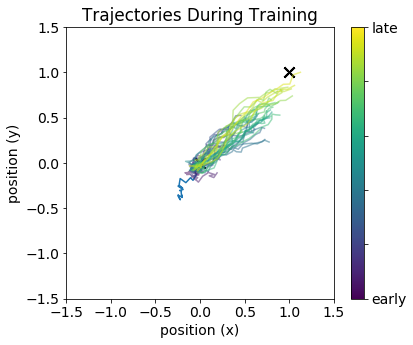

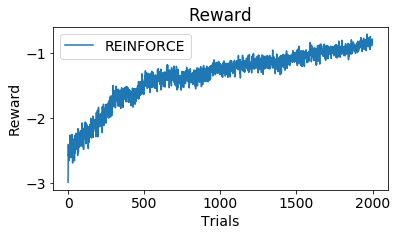

In [73]:
net1_pre = RNN(params)
net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1_pre.set_weights(w_out = w_out1)
net1_pre.set_weights(w_m = w_m.T)

# unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
net1 = RNN(params)
net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
net1.set_weights(w_out = w_out1)
net1.set_weights(w_m = w_m.T)




""" Track activity with new decoder, before training """

sim1_pre = Simulation(net1_pre)
trackvars = TrackVars(net1_pre,apply_to=[]) 
sim1_pre.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)
#fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

""" Train with new decoder """

sim1_train = Simulation(net1)
reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5)
sim1_train.run_session(n_trials=2000, tasks=[task1], learn_alg=[reinforce], probe_types=['h','pos','reward','err','w_rec'], plot=True, plot_freq=50)

""" Track activity with new decoder, after training """
net1_post = RNN(params)
net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
net1_post.set_weights(w_out = net1.w_out)
net1_post.set_weights(w_m = net1.w_m)

sim1_post = Simulation(net1_post)
trackvars = TrackVars(net1_post,apply_to=[]) 
sim1_post.run_session(n_trials=500, tasks=[task1], learn_alg=[trackvars], probe_types=['h','err','w_rec'], plot=False, plot_freq=10)


/Users/jacobportes/anaconda3/envs/pt/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


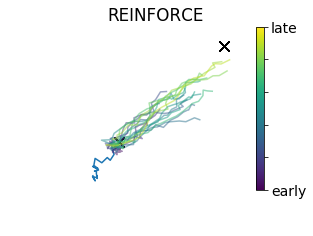

In [74]:
""" Plot example trajectories during training """
save = True
if save:
    lw, fs = paper_format()
    
fig,ax = plt.subplots(1,1,figsize=(4,3))
n_trials=2000
plot_freq = 100

for n in np.arange(0,n_trials,plot_freq):
    count = n
    fig = plot_position(fig=fig, pos=sim1_train.session_probes['pos'][n], tasks = [task1], n_trials=n_trials,count=count,plot_freq=plot_freq)
    
    
ax.set_xlim([-0.5,1.2])
ax.set_ylim([-0.5,1.2])
ax.set_axis_off()
fig.show()

if save:
    ax.set_title("REINFORCE")
    fig.savefig('reinforce-trajectories-example.pdf')

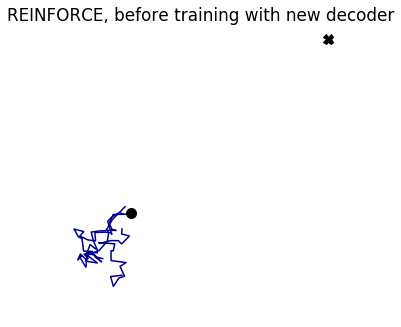

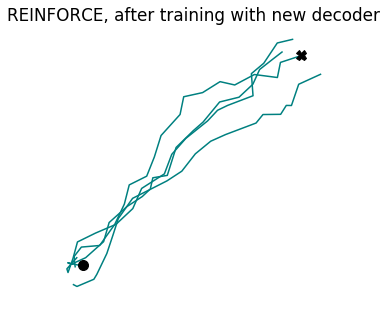

In [65]:
fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1],title='REINFORCE, before training with new decoder')

fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1],title='REINFORCE, after training with new decoder')


In [67]:
""" PCA on the weight updates """

rflo_pca = pca.explained_variance_ratio_

# concatenate data
W = sim1_train.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=50)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio


number of trials:  2000
n_samples,n_features:  (1999, 2500)
C:  (50, 2500)


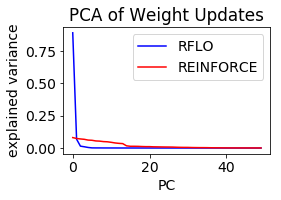

In [68]:
fig,ax=plt.subplots(1,1,figsize=(4,3))
plt.plot(rflo_pca,'-',color='b',label='RFLO')
plt.plot(pca.explained_variance_ratio_,'-',color='r',label='REINFORCE')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.legend()
plt.title('PCA of Weight Updates')
plt.tight_layout()
plt.show()


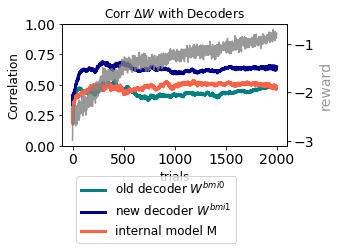

In [71]:
save = True

if save:
    lw,fs = paper_format()

fig,ax = plt.subplots(1,1,figsize=(5,4))



""" correlation with W_out.T using average error """
#av_error = np.mean(np.asarray(sim1_train.session_probes['err']),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs_w_out0=[]
corrs_w_out=[]
corrs_w_m=[]
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    
    delta_W_all.append(deltaW1)
    error = sim1_train.session_probes['err'][n].squeeze() # positions at trial n

    
    activity = sim1_train.session_probes['h'][n].squeeze() # activity at trial n
    delta_w_out0 = np.outer(net0.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # old decoder
    delta_w_out = np.outer(net1.w_out.T @ np.sum(error,axis=0), np.sum(activity,axis=0)) # new decoder
    delta_w_m = np.outer(net1.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0)) # internal model
    
    delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)
    
#     corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
#     corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])
    
    """ not the average """
    corrs_w_out0.append(np.corrcoef(delta_W_av.ravel(),delta_w_out0.ravel())[0,1])
    corrs_w_out.append(np.corrcoef(delta_W_av.ravel(),delta_w_out.ravel())[0,1])
    corrs_w_m.append(np.corrcoef(delta_W_av.ravel(),delta_w_m.ravel())[0,1])

ax.plot(corrs_w_out0,'-',label='old decoder '+r'$W^{bmi0}$',color='teal',linewidth=3)
ax.plot(corrs_w_out,'-',label='new decoder '+r'$W^{bmi1}$',color='darkblue',linewidth=3)
ax.plot(corrs_w_m,'-',label='internal model M',color='tomato',linewidth=3)
plt.ylim([0,1])



ax1 = ax.twinx()
reward = np.mean(np.asarray(sim1_train.session_probes['reward']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(reward,color='gray',alpha=0.8)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('reward',color='gray',alpha=0.8)
#ax1.set_yscale('log')
#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.2))
plt.title('Correlation of \dW with Decoders')
ax.set_ylabel('Correlation')
ax.set_xlabel('trials')


ax.legend(bbox_to_anchor=(0.8,-0.2),fontsize=fs)
plt.title('Corr '+r'$\Delta W$'+ ' with Decoders',fontsize=fs)
ax.set_ylabel('Correlation',fontsize=fs)
ax.set_xlabel('trials',fontsize=fs)
plt.tight_layout()


if save:
    fig.savefig('reinforce-W-correlation.pdf')